# Road Accident Severity Prediction
This notebook demonstrates how to predict accident severity using XGBoost based on weather, lighting, and road conditions.

In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

## Category Mappings
These dictionaries define the meaning of encoded categorical variables.

In [4]:
WEATHER_CONDITIONS = {
    1: 'Fine no high winds',
    2: 'Raining no high winds',
    3: 'Snowing no high winds',
    4: 'Fine + high winds',
    5: 'Raining + high winds',
    6: 'Snowing + high winds',
    7: 'Fog or mist',
    8: 'Other',
    9: 'Unknown'
}

LIGHT_CONDITIONS = {
    1: 'Daylight',
    2: 'Darkness - lights lit',
    3: 'Darkness - lights unlit',
    4: 'Darkness - no lighting',
    5: 'Darkness - lighting unknown',
    6: 'Unknown'
}

ROAD_SURFACE = {
    1: 'Dry',
    2: 'Wet/Damp',
    3: 'Snow',
    4: 'Frost/Ice',
    5: 'Flood',
    6: 'Oil/Diesel',
    7: 'Mud'
}

## Load and Explore Data

In [5]:
# Load the data
df = pd.read_csv('accident_analysis_export.csv')

# Display basic information
print("Dataset Shape:", df.shape)
print("\nFeature Info:")
df.info()

Dataset Shape: (2806, 49)

Feature Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2806 entries, 0 to 2805
Data columns (total 49 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   accident_index                               2806 non-null   float64
 1   accident_year                                2806 non-null   int64  
 2   accident_reference                           2806 non-null   int64  
 3   location_easting_osgr                        2806 non-null   int64  
 4   location_northing_osgr                       2806 non-null   int64  
 5   longitude                                    2806 non-null   float64
 6   latitude                                     2806 non-null   float64
 7   police_force                                 2806 non-null   int64  
 8   accident_severity                            2806 non-null   int64  
 9   number_of_vehicles               

## Data Preprocessing

In [6]:
def preprocess_data(df):
    features = [
        'light_conditions', 'weather_conditions', 'road_surface_conditions',
        'road_type', 'speed_limit', 'urban_or_rural_area',
        'junction_detail', 'number_of_vehicles', 'number_of_casualties'
    ]
    
    df_model = df[features + ['accident_severity']].copy()
    df_model = df_model.fillna(-1)
    
    return df_model

# Preprocess the data
df_processed = preprocess_data(df)
print("Processed features:\n")
print(df_processed.head())

Processed features:

   light_conditions  weather_conditions  road_surface_conditions  road_type  \
0                 1                   1                        2          6   
1                 1                   4                        2          6   
2                 1                   5                        2          6   
3                 4                   5                        2          1   
4                 1                   2                        2          3   

   speed_limit  urban_or_rural_area  junction_detail  number_of_vehicles  \
0           30                    2                3                   2   
1           60                    2                0                   2   
2           30                    1                3                   2   
3           30                    1                0                   2   
4           30                    1                1                   2   

   number_of_casualties  accident_severity  
0 

## Model Training and Evaluation

In [9]:
def preprocess_data(df):
    features = [
        'light_conditions', 'weather_conditions', 'road_surface_conditions',
        'road_type', 'speed_limit', 'urban_or_rural_area',
        'junction_detail', 'number_of_vehicles', 'number_of_casualties'
    ]
    
    df_model = df[features + ['accident_severity']].copy()
    df_model = df_model.fillna(-1)
    
    # Adjust severity labels to start from 0 (subtract 1)
    df_model['accident_severity'] = df_model['accident_severity'] - 1
    
    return df_model

def train_model(df):
    df_model = preprocess_data(df)
    
    X = df_model.drop('accident_severity', axis=1)
    y = df_model['accident_severity']
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    model = XGBClassifier(
        learning_rate=0.1,
        max_depth=5,
        n_estimators=100,
        random_state=42
    )
    
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    return model, X_test, y_test, y_pred

# Train the model
model, X_test, y_test, y_pred = train_model(df)

## Model Performance Analysis

Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         8
           1       0.20      0.01      0.01       138
           2       0.74      0.99      0.85       416

    accuracy                           0.73       562
   macro avg       0.31      0.33      0.29       562
weighted avg       0.60      0.73      0.63       562



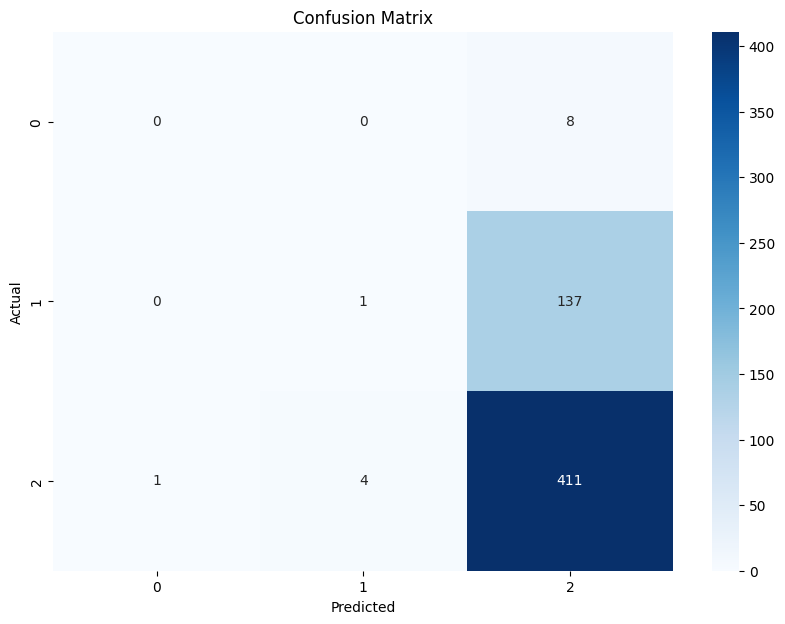

In [10]:
# Classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Confusion matrix visualization
plt.figure(figsize=(10,7))
sns.heatmap(confusion_matrix(y_test, y_pred), 
            annot=True, 
            fmt='d', 
            cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

## Feature Importance Analysis

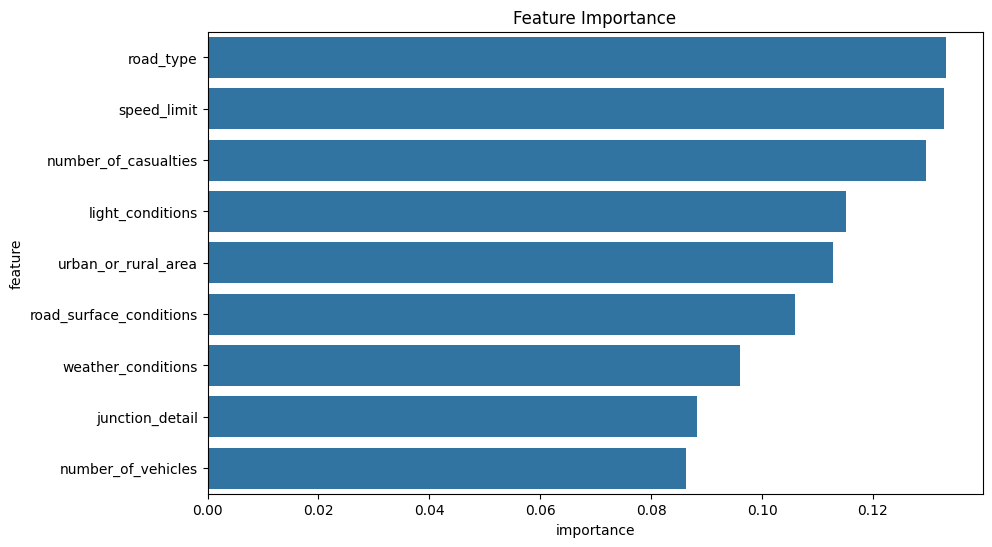

In [11]:
# Plot feature importance
importance_df = pd.DataFrame({
    'feature': X_test.columns,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(data=importance_df, x='importance', y='feature')
plt.title('Feature Importance')
plt.show()

## Prediction Function

In [12]:
def predict_risk(model, light_condition, weather_condition, road_surface, road_type,
                speed_limit, urban_rural, junction, num_vehicles, num_casualties):
    """Make prediction with actual category values"""
    input_data = pd.DataFrame([[light_condition, weather_condition, road_surface, road_type,
                               speed_limit, urban_rural, junction, num_vehicles, num_casualties]],
                             columns=['light_conditions', 'weather_conditions', 'road_surface_conditions',
                                     'road_type', 'speed_limit', 'urban_or_rural_area',
                                     'junction_detail', 'number_of_vehicles', 'number_of_casualties'])
    return model.predict(input_data)[0]

# Example prediction
example_prediction = predict_risk(
    model,
    light_condition=1,    # Daylight
    weather_condition=1,  # Fine no high winds
    road_surface=1,       # Dry
    road_type=1,
    speed_limit=30,
    urban_rural=1,
    junction=1,
    num_vehicles=2,
    num_casualties=1
)

print(f"Predicted severity: {example_prediction}")

Predicted severity: 2


## Export the Severity Prediction Model

In [13]:
model.save_model('accident_model.json')